<a href="https://colab.research.google.com/github/mohamedelshami/AKAP/blob/master/kyc_notes2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Imports
import io
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter
sns.set()

# hide all warnings for better readability. TODO: fix with timezone future warnings
warnings.filterwarnings('ignore')

In [0]:
doc_df = pd.read_csv("https://raw.githubusercontent.com/jordiclive/Revolut_KYC_Exercise/master/data/doc_reports.csv", sep=",")
face_df = pd.read_csv("https://raw.githubusercontent.com/jordiclive/Revolut_KYC_Exercise/master/data/facial_similarity_reports.csv", sep=",")

data_df = doc_df.join(face_df, how="left", lsuffix="_dc")
# drop row id columns
data_df = data_df.drop(["Unnamed: 0_dc", "Unnamed: 0"], 1)
# assert consistent records between joined dataset, document and facial reports
assert True == (len(data_df) == len(doc_df) == len(face_df))
# convert created_at to datetime type
data_df.created_at_dc = pd.to_datetime(data_df.created_at_dc)
data_df.created_at = pd.to_datetime(data_df.created_at)

The customer will ‘pass’ the KYC process and get onboarded if the results of both Document and Facial Similarity checks are ‘clear’. If the result of any check is not ‘clear’, the customer has to submit all the photos again.

In [0]:
# add kyc pass column. A kyc is pass when both document check and face verification results are clear
data_df = data_df.assign(kyc_pass=(data_df.result_dc == 'clear') & (data_df.result == 'clear'))
#data_df[ data_df.user_id == "3b0a8e16846b4d779c5ba9e5499391af" ].head()

### Each customer has up to 2 attempts. It appears that 22% of users have multiple attempts. 

Some users have retried the KYC, although they've succeded the first attempt - I suspect that users were not prompted on time when the KYC completed either missed email notification or for some reason they deliberty retried. This is could also be user experience issue. 

In [0]:
unique_data_df = data_df.sort_values(["kyc_pass", "created_at_dc"]).drop_duplicates("user_id_dc", keep="last")
attempts = data_df[["user_id", "attempt_id"]].groupby(["user_id"]).count()
multiple_attempts_ratio = int(attempts[attempts.attempt_id > 1].count()) / len(unique_data_df)

### Obverving the number of users who have attempted the KYC check multiple times. We find 22% of users have made multiple KYC attempts.



# Pass Rate Analysis

The “pass rate” is defined as the number of customers who pass both the KYC process divided by the number of customers who attempt the process. Each customer has up to 2 attempts. The pass rate has decreased substantially in the recent period.


In [6]:
pass_rate = unique_data_df[ unique_data_df.kyc_pass == True ].user_id_dc.count() / unique_data_df.user_id_dc.count()
pass_rate

0.8509220593593229

### Now let's actually investigate whether the pass rate is indeed has been decreasing over the recent period.

(<matplotlib.axes._subplots.AxesSubplot at 0x7fd41fb56ac8>,)

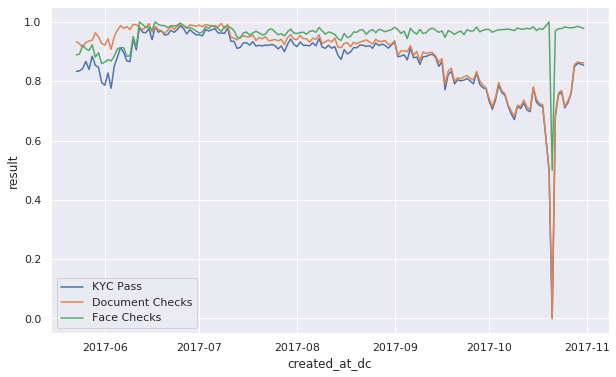

In [7]:
kyc_over_time = unique_data_df.copy()

kyc_over_time.kyc_pass = kyc_over_time.kyc_pass.astype(int)
kyc_over_time.result_dc = kyc_over_time.result_dc.apply(lambda x: 1 if x == "clear" else 0)
kyc_over_time.result = kyc_over_time.result.map(lambda c: 1 if c == "clear" else 0)

pass_plot = kyc_over_time.groupby(pd.Grouper(key='created_at_dc', freq='D'))['kyc_pass', 'result', 'result_dc'].mean()

fig = plt.figure(figsize=(10,6))
sns.lineplot(x=pass_plot.index, y="kyc_pass", data=pass_plot, label="KYC Pass", legend="full")
sns.lineplot(x=pass_plot.index, y="result_dc", data=pass_plot, label="Document Checks", legend="full")
sns.lineplot(x=pass_plot.index, y="result", data=pass_plot, label="Face Checks", legend="full")

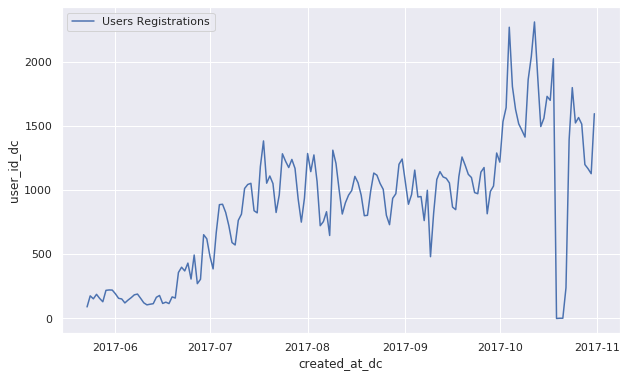

In [8]:
fig = plt.figure(figsize=(10,6))
users_plot = kyc_over_time.groupby(pd.Grouper(key='created_at_dc', freq='D'))['user_id_dc'].count()
sns.lineplot(x=pass_plot.index, y=users_plot, label="Users Registrations")

As we can see from the two charts above, the document checks pass rate has been decreasing while the face checks pass rate has remained steady over the same time period.

The pass rate decline has positive correction with the increasing number of users.

We will further look at other factors which might affect the pass rate. Assuming there's no change in Veritas API and the algorithm performing the document checks, the key factors include:



In [0]:
#res = df[ df.kyc_pass == False ].groupby( ['visual_authenticity_result_dc',] )['kyc_pass'].count()
#res = df[ df.kyc_pass == False ].pivot_table( values=document_columns, columns=['result_dc'], aggfunc='count', )

#sns.scatterplot(x=res.index, y="clear", data=res.data_validation_result)
#sns.heatmap(res, annot=True, linewidths=.5)

In [171]:
df = unique_data_df.copy()
# create new data frame to hold a simplified structure for the check counts by each category
kyc_result_summary = pd.DataFrame(columns=["check_category", "check_type", "check_counts", "sub_result"])

doc_columns = ["visual_authenticity_result_dc", 
               "image_integrity_result", 
               "face_detection_result",
               "image_quality_result", 
               "supported_document_result",
               "conclusive_document_quality_result",
               "colour_picture_result",
               "data_validation_result", 
               "data_consistency_result",
               "data_comparison_result", 
               "police_record_result",
               "compromised_document_result",
               "sub_result"] 

face_columns = ["face_comparison_result",
               "facial_image_integrity_result",
               "visual_authenticity_result"]

def append_result_df(result_df, columns, check_type):
    for col in columns:
        for key, count in df[col].value_counts().items():
            result_df = result_df.append( {"check_category": col, "check_type": check_type, "check_counts": count, "sub_result": key}, ignore_index=True )
    return result_df

kyc_result_summary = append_result_df(kyc_result_summary, doc_columns, "document")
kyc_result_summary = append_result_df(kyc_result_summary, face_columns, "face")

kyc_result_summary[kyc_result_summary.sub_result != "clear"].sort_values("check_counts")

,check_category,check_type,check_counts,sub_result
23,compromised_document_result,document,11,consider
21,police_record_result,document,15,consider
13,colour_picture_result,document,57,consider
17,data_consistency_result,document,71,consider
19,data_comparison_result,document,117,consider
5,face_detection_result,document,225,consider
29,face_comparison_result,face,280,consider
9,supported_document_result,document,741,unidentified
15,data_validation_result,document,789,consider
27,sub_result,document,956,suspected


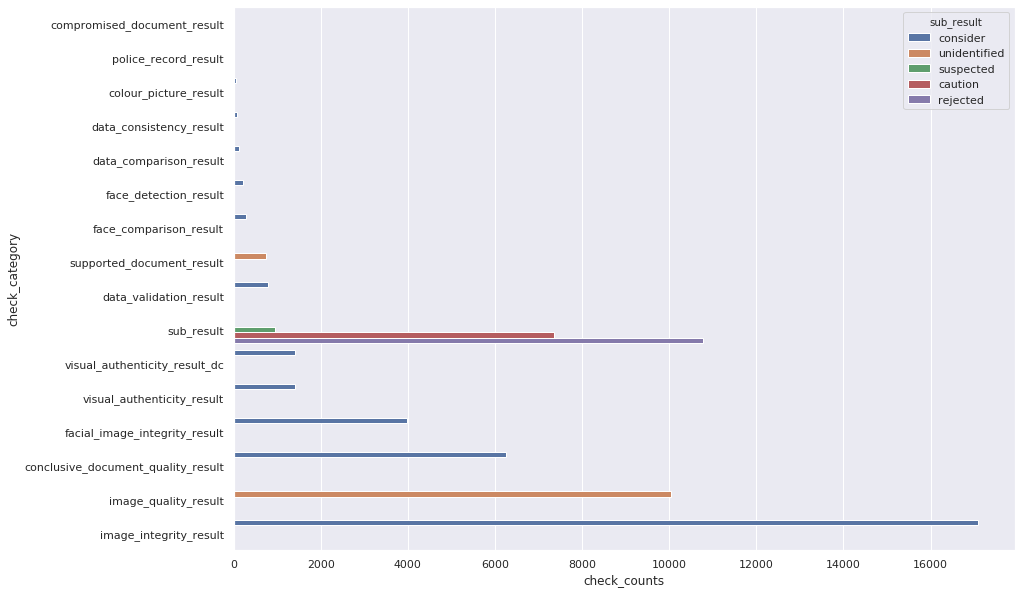

In [172]:
fig = plt.figure(figsize=(14,10))
sns.barplot(x="check_counts", y="check_category", hue="sub_result", data=kyc_result_summary[ kyc_result_summary.sub_result != "clear"].sort_values("check_counts") )

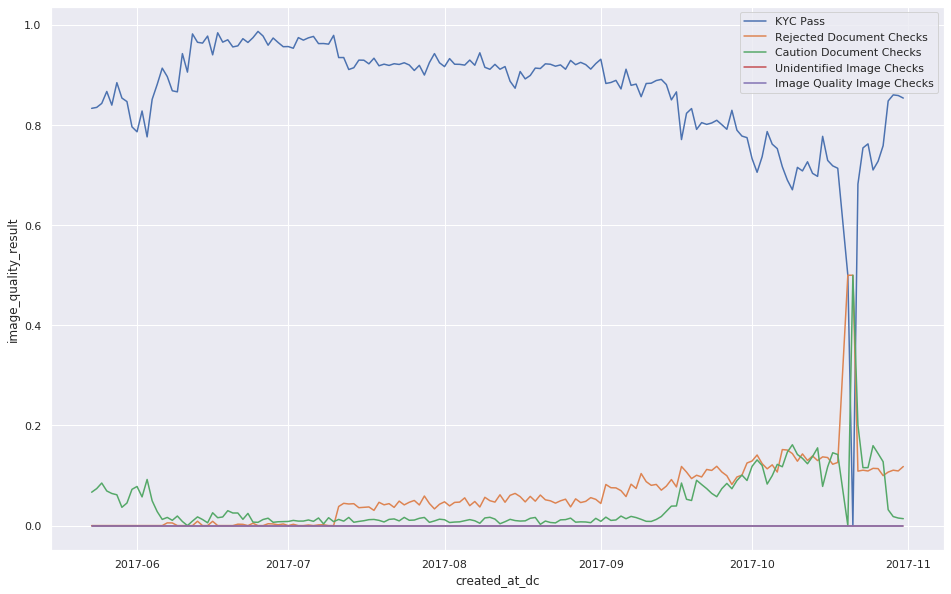

In [185]:
kyc_pass_rate_df = unique_data_df.copy()
kyc_pass_rate_df.kyc_pass = kyc_pass_rate_df.kyc_pass.astype(int)

kyc_pass_rate_df["caution"] = kyc_pass_rate_df.sub_result.map(lambda c: 1 if c == "caution" else 0)
kyc_pass_rate_df["rejected"] = kyc_pass_rate_df.sub_result.map(lambda c: 1 if c == "rejected" else 0)
kyc_pass_rate_df["unidentified"] = kyc_pass_rate_df.sub_result.map(lambda c: 1 if c == "unidentified" else 0)
kyc_pass_rate_df["image_quality_result"] = kyc_pass_rate_df.sub_result.map(lambda c: 1 if c == "consider" else 0)

kyc_rate_plot = kyc_pass_rate_df.groupby(pd.Grouper(key='created_at_dc', freq='D'))['kyc_pass', 'caution', 'rejected', 'unidentified', 'image_quality_result'].mean()

fig = plt.figure(figsize=(16,10))
sns.lineplot(x=kyc_rate_plot.index, y="kyc_pass", data=kyc_rate_plot, label="KYC Pass")
sns.lineplot(x=kyc_rate_plot.index, y="rejected", data=kyc_rate_plot, label="Rejected Document Checks")
sns.lineplot(x=kyc_rate_plot.index, y="caution", data=kyc_rate_plot, label="Caution Document Checks")
sns.lineplot(x=kyc_rate_plot.index, y="unidentified", data=kyc_rate_plot, label="Unidentified Image Checks")
sns.lineplot(x=kyc_rate_plot.index, y="image_quality_result", data=kyc_rate_plot, label="Image Quality Image Checks")